# **Custos Médicos: Melhores Modelos (usando PyCaret como base)**

A ideia neste problema é estimar o custo do seguro no plano de saúde para uma pessoa com base em dados adicionais como idade, se é fumante ou não, se tem dependentes, etc.

Isto quer dizer que temos considerar que nuestra variável dependiente será o **_Custo_** e as caraterísticas restantes serão consideradas como as variáveis independientes, em outras palavras o **Custo** depende (umas vezes mais e outras menos) de todas as outras variáveis

O Primeiro a fazer é estabelecer a influencia de todas essas variáveis (caraterísticas) no valor final dos Custos Médicos, de forma individual.

**_É importante lembrar que temos que ter a capacidade de predecir um valor de custo para uma nova pessoa (cliente) com base as suas proprias caraterísticas_.**

Iniciemos esta análise selecionando os dados que vamos a utilizar.

---
## Importação e Preparação dos Dados

Vamos utilizar uma biblioteca que é considerada para fazer ML automática. Para isso temos que instalar a biblioteca 

_pycaret_ (algumas vezes pode dar problema na instalação, para meu caso so funcionou a instalação de uma versão anterior v2.3.10)

Lembrete: 
* instalar pycaret
* comentar e 
* reiniciar ambiente de excecução

In [ ]:
#!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq

In [ ]:
#!pip install jinja2
#!pip install markupsafe==2.0.1
#import jinja2

O pycaret: tem uma base com muitos dados para usar como exemplos, e para isso podemos usar a função get_data

Poderiamos usar os dados que ja tinhamos utilizado para o caso de regressão ou classificação (esta dentro da biblioteca pycaret).

In [ ]:
from pycaret.datasets import get_data
#get_data('index')

Chamando os dados insurance:

In [ ]:
dados = get_data('insurance') 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Mise en place para Modelagem

Em Machine Learning, em geral, todas as variáveis do conjunto de dados que será utilizado precisam ser númericas. É também interessante que o intervalo de variabilidade das variáveis contínuas não seja tão grande e esteja próximo de zero.

Para tanto, façamos as seguintes transformações:

* Transformar a variável **Fumante** em 0 (não) ou 1 (sim)
* Colocar a variável resposta na escala para cada mil dolares.

Nesta primeira análise vamos considerar só as variáveis:
* var. dependiente: **Custos**
* var. independientes: índice de massa corporal (**IMC**) e ser fumante ou não.
* var. independiente: **sexo** (Homem = 1 ou Mulher = 0.)
* var. independiente: **Idade** variavel contínua.
* var. independiente: **filhos** -> **filhos>1**, (2,3,4,5 filhos) o custo é maior, (Sim = 1 ou Não = 0)
* var. independiente: **região** -> **Region_East**, valores menores para a região leste que no oeste (Sim = 1 ou Não = 0) 

In [ ]:
dados['smoker'] = dados['smoker'].map({'yes': 1, 'no': 0})
dados['charges'] = dados['charges']/1000 
dados['sex'] = dados['sex'].map({'male': 1, 'female': 0})
#dados.head()

In [ ]:
def aux(x):
    if x == 0 or x == 1:
        return 0
    else:   
        return 1  

dados['children>1'] = dados['children'].apply(aux)

In [ ]:
def aux(x):
    if x == 'southwest' or x == 'northwest':
        return 0
    else:   
        return 1  

dados['Region_East'] = dados['region'].apply(aux)

In [ ]:
dados = dados[['sex', 'age', 'bmi', 'children>1', 'Region_East','smoker','charges']]
dados.head()

,sex,age,bmi,children>1,Region_East,smoker,charges
0,0,19,27.900,0,0,1,16.884924
1,1,18,33.770,0,1,0,1.725552
2,1,28,33.000,1,1,0,4.449462
3,1,33,22.705,0,0,0,21.984471
4,1,32,28.880,0,0,0,3.866855


## Objetivo: Construir um modelo para previsão dos custos médicos de uma pessoa

A biblioteca pycaret tem uma função que permite fazer a regressão usando uma serie de parâmetros que temos que definir:

* setup
* models
* create model
* ...

In [ ]:
# funções que iremos utilizar do PyCaret
from pycaret.regression import setup, models, create_model, tune_model, \
                               compare_models, blend_models, stack_models, \
                               predict_model, evaluate_model, \
                               finalize_model, save_model, load_model

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Na função setup temos que definir os dados e a variável alvo. 

Tem muitos (quase 60) argumentos por default, vamos a normalizar (colocamos False), não queremos mudar nossa normalização.

A engenharia de dados, não pode ser feita automaticamente!!!

In [ ]:
# configuração da regressão
regressao = setup(data = dados, target = 'charges', normalize = False)

,Description,Value
0,session_id,7598
1,Target,charges
2,Original Data,"(1338, 7)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(936, 6)"


De toda esta seleção de modelos, podemos escolher o que nos interessa. A forma de chamar é utilizando o identificador. 

In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


**Lembrar as Métricas: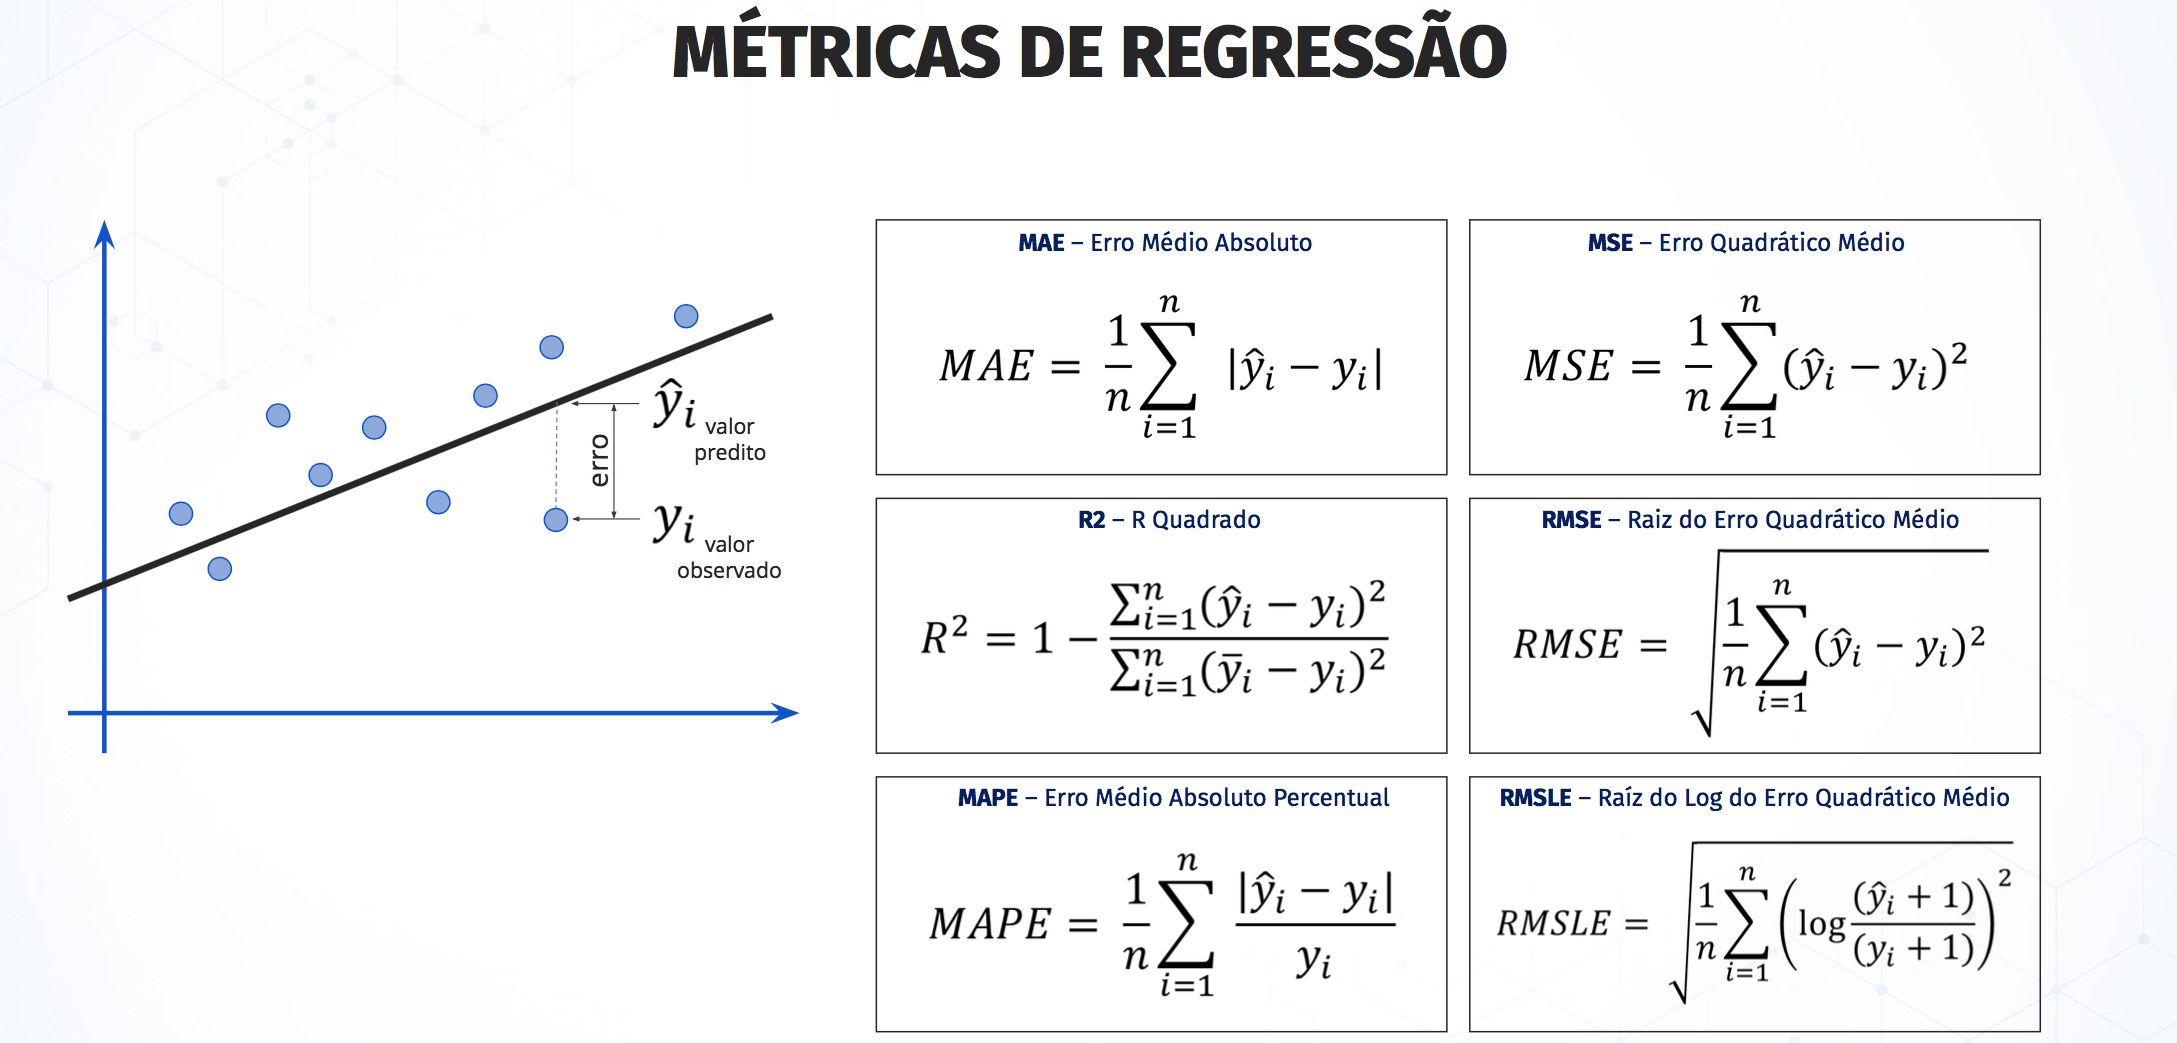**

Podemos comparar os modelos que aparecem, ja que o pycaret tem a função _compare_models_ e va selecionar com _n_select_ = 5,  os 5 melhores em função a métrica **MSE** = Erro Quadrático Médio que era a que utilizamaos como referência.

In [ ]:
# Comparando os modelos implementados, ordenando pelo RMSLE
melhores = compare_models(sort = 'MSE', n_select = 5)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2.4563,20.3099,4.4641,0.8603,0.3656,0.3038,0.077
lightgbm,Light Gradient Boosting Machine,2.7710,22.6672,4.7288,0.8440,0.4168,0.3559,0.083
rf,Random Forest Regressor,2.7220,23.8493,4.8527,0.8358,0.4058,0.3409,0.506
ada,AdaBoost Regressor,3.8211,25.3865,5.0202,0.8255,0.4948,0.6462,0.028
et,Extra Trees Regressor,2.8205,28.4418,5.3132,0.8052,0.4313,0.3501,0.458
ridge,Ridge Regression,4.1936,36.1671,5.9796,0.7533,0.4559,0.4368,0.029
lr,Linear Regression,4.1814,36.1681,5.9788,0.7533,0.4562,0.4344,0.676
lar,Least Angle Regression,4.1814,36.1681,5.9788,0.7533,0.4562,0.4344,0.025
br,Bayesian Ridge,4.1860,36.1683,5.9792,0.7533,0.4561,0.4353,0.035
dt,Decision Tree Regressor,3.1112,40.3561,6.3095,0.7214,0.4696,0.3790,0.015


Vamos começar usando os modelos:

* Gradient Boosting Regresso = gbr
* Random Forest Regressor = rf

Para criar o modelo usamos a função create_model

Se repete 10 vezes e calcula as métricas, as médias e o desvio padrão.

In [ ]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3626,16.0984,4.0123,0.8900,0.3596,0.3289
1,2.4943,18.8450,4.3411,0.8612,0.3543,0.3032
2,2.5222,20.8327,4.5643,0.8851,0.3750,0.3293
3,2.1356,17.4006,4.1714,0.8617,0.3168,0.2794
4,3.1251,32.6243,5.7118,0.7779,0.4593,0.2744
5,2.1582,16.2390,4.0298,0.9023,0.2495,0.2197
6,2.5625,23.7497,4.8734,0.8506,0.4130,0.3560
7,2.6856,27.7661,5.2694,0.7690,0.4193,0.2915
8,2.4342,16.8698,4.1073,0.8873,0.3738,0.3317


Tunando o melhor modelo - **gbr**

In [ ]:
gbr_tunado = tune_model(gbr, optimize = 'MSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3707,17.6390,4.1999,0.8795,0.3506,0.2628
1,2.9823,24.1364,4.9129,0.8222,0.4058,0.3701
2,2.6645,20.6071,4.5395,0.8864,0.3925,0.3962
3,2.5416,19.7905,4.4487,0.8427,0.3424,0.2999
4,3.3596,33.8160,5.8152,0.7698,0.4872,0.3266
5,2.6081,20.9093,4.5727,0.8742,0.3379,0.3106
6,3.0627,27.5622,5.2500,0.8266,0.4470,0.4298
7,2.8197,27.8710,5.2793,0.7682,0.4424,0.3062
8,3.1970,22.2719,4.7193,0.8512,0.4147,0.4397


De toda esta análise vamos utilizar o melhor modelo, que para este caso foi o **gbr** e fazer a predição. Para isso usamos a função _predict_model_

A função _pred_ me mostra os dados e os resultados e a previsão (label)

A função _evaluate_model_ nos fornece as estimativas que sairam da execução do modelo. A apresentação destes parâmetros é em forma iterativa.

In [ ]:
# Performance nos dados de validacao
pred = predict_model(gbr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.5984,23.8803,4.8867,0.8284,0.3741,0.2959


In [ ]:
pred

,age,bmi,sex_0,children>1_1,Region_East_1,smoker_1,charges,Label
0,18.0,33.330002,0.0,0.0,1.0,0.0,1.135941,4.303305
1,51.0,39.700001,0.0,0.0,0.0,0.0,9.391346,11.136449
2,20.0,37.000000,1.0,1.0,0.0,0.0,4.830630,4.991538
3,22.0,28.879999,0.0,0.0,1.0,0.0,2.250835,2.400898
4,42.0,35.799999,0.0,1.0,0.0,0.0,7.160094,7.857164
...,...,...,...,...,...,...,...,...
397,51.0,24.795000,0.0,1.0,0.0,1.0,23.967382,24.739183
398,63.0,41.325001,0.0,1.0,0.0,0.0,15.555189,27.170517
399,57.0,40.369999,0.0,0.0,1.0,0.0,10.982501,12.818838
400,51.0,30.030001,0.0,0.0,1.0,0.0,9.377905,10.308263


In [ ]:
evaluate_model(gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

---
---

In [ ]:
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.5577,17.6928,4.2063,0.8791,0.3595,0.3292
1,3.1622,27.5168,5.2456,0.7973,0.4876,0.5030
2,2.5162,21.4155,4.6277,0.8819,0.3351,0.2551
3,2.3209,19.4076,4.4054,0.8457,0.3181,0.2730
4,3.2848,33.1152,5.7546,0.7746,0.4698,0.2788
5,2.5198,23.6344,4.8615,0.8579,0.3879,0.3494
6,2.6949,26.8077,5.1776,0.8313,0.4492,0.3547
7,3.0051,31.8823,5.6464,0.7348,0.4859,0.3492
8,2.8093,19.4658,4.4120,0.8699,0.3981,0.3796


In [ ]:
rf_tunado = tune_model(rf, optimize = 'MSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2109,13.3294,3.6509,0.9089,0.3148,0.2960
1,2.5493,17.8003,4.2190,0.8689,0.3509,0.3319
2,2.4641,19.9104,4.4621,0.8902,0.3524,0.3035
3,2.3156,18.0631,4.2501,0.8564,0.3255,0.3015
4,3.1937,31.6308,5.6241,0.7847,0.4313,0.2798
5,2.5005,20.1645,4.4905,0.8787,0.2981,0.2646
6,2.6458,22.8093,4.7759,0.8565,0.4003,0.3547
7,2.7505,26.6602,5.1633,0.7782,0.4110,0.3142
8,2.4113,15.6983,3.9621,0.8951,0.3392,0.3166


In [ ]:
# Performance nos dados de validacao
pred = predict_model(rf_tunado)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.6124,22.7777,4.7726,0.8363,0.3585,0.2937


In [ ]:
pred

,age,bmi,sex_0,children>1_1,Region_East_1,smoker_1,charges,Label
0,18.0,33.330002,0.0,0.0,1.0,0.0,1.135941,2.989692
1,51.0,39.700001,0.0,0.0,0.0,0.0,9.391346,11.142188
2,20.0,37.000000,1.0,1.0,0.0,0.0,4.830630,5.915352
3,22.0,28.879999,0.0,0.0,1.0,0.0,2.250835,2.839409
4,42.0,35.799999,0.0,1.0,0.0,0.0,7.160094,7.530753
...,...,...,...,...,...,...,...,...
397,51.0,24.795000,0.0,1.0,0.0,1.0,23.967382,23.952235
398,63.0,41.325001,0.0,1.0,0.0,0.0,15.555189,16.651503
399,57.0,40.369999,0.0,0.0,1.0,0.0,10.982501,13.363155
400,51.0,30.030001,0.0,0.0,1.0,0.0,9.377905,11.011156


In [ ]:
evaluate_model(rf_tunado)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

---
---

Podemos combinar o melhores modelos (n_select = 5) usando a função _blend_models_

In [ ]:
modelo_combinado = blend_models(melhores)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.5167,16.0252,4.0031,0.8905,0.3531,0.3480
1,2.9385,21.7733,4.6662,0.8396,0.4308,0.4475
2,2.6220,19.9841,4.4704,0.8898,0.3620,0.3465
3,2.3898,18.6599,4.3197,0.8517,0.3330,0.3147
4,3.3011,31.0116,5.5688,0.7889,0.4499,0.3163
5,2.5882,20.1604,4.4900,0.8787,0.3413,0.3357
6,2.8367,24.8044,4.9804,0.8439,0.4331,0.4110
7,2.9997,28.2797,5.3179,0.7648,0.4569,0.3936
8,2.7830,18.0580,4.2495,0.8793,0.3942,0.4022


Cria um modelo  de uma forma específica (média ponerada)

In [ ]:
modelo_stack = stack_models(melhores)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1374,14.7856,3.8452,0.8990,0.3302,0.2764
1,2.5043,18.6529,4.3189,0.8626,0.3586,0.3105
2,2.4312,20.5862,4.5372,0.8865,0.3590,0.2860
3,2.3774,18.8703,4.3440,0.8500,0.3417,0.3104
4,3.0702,31.2414,5.5894,0.7873,0.4551,0.2716
5,2.6878,18.8291,4.3392,0.8868,0.2907,0.2788
6,2.5827,22.9929,4.7951,0.8553,0.3847,0.3155
7,2.8485,28.8670,5.3728,0.7599,0.4426,0.3163
8,2.4082,16.7703,4.0952,0.8879,0.3826,0.3140


In [ ]:
# Performance nos dados de validacao
pred = predict_model(modelo_stack)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2.6275,23.4001,4.8374,0.8319,0.3798,0.2871


In [ ]:
pred

,age,bmi,sex_0,children>1_1,Region_East_1,smoker_1,charges,Label
0,18.0,33.330002,0.0,0.0,1.0,0.0,1.135941,2.876454
1,51.0,39.700001,0.0,0.0,0.0,0.0,9.391346,11.219521
2,20.0,37.000000,1.0,1.0,0.0,0.0,4.830630,5.933355
3,22.0,28.879999,0.0,0.0,1.0,0.0,2.250835,2.546071
4,42.0,35.799999,0.0,1.0,0.0,0.0,7.160094,8.479388
...,...,...,...,...,...,...,...,...
397,51.0,24.795000,0.0,1.0,0.0,1.0,23.967382,25.980788
398,63.0,41.325001,0.0,1.0,0.0,0.0,15.555189,22.831675
399,57.0,40.369999,0.0,0.0,1.0,0.0,10.982501,13.073852
400,51.0,30.030001,0.0,0.0,1.0,0.0,9.377905,10.476508


In [ ]:
evaluate_model(modelo_stack)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

---
---

Para finalizar, depois de ter escolhido o melhor modelo ajustamos este modelo con todos os dados.

In [ ]:
# Utilizando o modelo escolhido nos dados todos para gerar o modelo final
modelo_final = finalize_model(rf_tunado)

Salvamos o modelo usando a biblioteca _pickle_, que é responsavel por salvar objetos no python.

In [ ]:
# Salvando o modelo
save_model(modelo_final, 'meu-melhor-modelo-para-charges')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='charges',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=4,
                                        max_features=1.0, max_leaf_nodes=None,
                                        max_samples=None,
                                   

---
---

## Deploy Básico

Tendo determinado nosso melhor modelo, podemos calcular com novos valores (para novos clientes) o valor dos custo médicos (**charge**). Para isto criamos uma função baseada no modelo determinado, e insirindo os parâmetros (caraterísticas do cliente) obter o valor dos Custos.

* Primero chamamos (carregar) o modelo
* Definimos a função que tem como argumentos todas as variáveis do modelo
  * as variáveis son colocadas em um dicionario 
  * o dicionario é transformado em um DataFrame
  * chama a funcação predict (modelo, dados)  e usa o com o dicionario

* e por último, usar!!!  

In [ ]:
import pandas as pd
modelo = load_model('meu-melhor-modelo-para-charges')

def valoresoriginais(sex, children, smoker, region):
    valores = []
    if (sex=='male'):
      sex = 1
    else:
      if (sex=='female'):
          sex = 0
      else: 
          print('verifique os valores')   
    valores.append(sex) 
    if (children >= 2): 
        children = 1
    else:
        children = 0
    valores.append(children)    
    if (smoker == 'yes'):       
        smoker = 1
    else:
        smoker = 0
    valores.append(smoker)  
    if (region == 'southwest' or region == 'northwest'):
        region = 0
    else:
        region = 1   
    valores.append(region)       
    return valores        

def CustoSeguro(age, sex, bmi, children, smoker, region):
    valores=valoresoriginais(sex, children, smoker, region)
    dados0 = {'sex': valores[0],'age': [age], 'bmi': [bmi], 'children>1': valores[1], 'Region_East': valores[3], 'smoker': valores[2]}
    dados = pd.DataFrame(dados0)
    print(dados)

    pred = float(predict_model(modelo, data = dados)['Label'].round(5))  

    print('Custo do Seguro: ${}'.format(pred*1000)) 


Transformation Pipeline and Model Successfully Loaded


In [ ]:
CustoSeguro(age = 31, 
            sex = 'male', 
            bmi = 25, 
            children = 0, 
            smoker =  'yes', 
            region = 'southwest')

   sex  age  bmi  children>1  Region_East  smoker
0    1   31   25           0            0       1
Custo do Seguro: $19054.22


In [ ]:
CustoSeguro(60, 'female', 30, 2, 'yes', 'southwest')

   sex  age  bmi  children>1  Region_East  smoker
0    0   60   30           1            0       1
Custo do Seguro: $31926.54
